<h1><center>Space missions data understanding, visualization and analysis</center></h1>

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:Black; border:0' role="tab" aria-controls="home"><center>Quick navigation</center></h3>

* [1. General dataset overview](#1)
* [2. Geo analysis](#2)
* [3. Other imnteresting questions](#3)
* [4. USA vs USSR analysis](#4)
* [5. Best every year](#5)
* [6. Time series decomposition](#6)
* [7. Where India stands](#7)

In [1]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from iso3166 import countries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from collections import OrderedDict

<a id="1"></a>
<h1 style='background:black; border:0; color:white'><center>1. Lets see how's the data in our dataset<center><h1>

In [2]:
df = pd.read_csv('dataset/Space_Corrected.csv')

df.columns = [
    'Unnamed: 0', 
    'Unnamed: 0.1', 
    'Company Name', 
    'Location', 
    'Datum', 
    'Detail', 
    'Status Rocket', 
    'Rocket', 
    'Status Mission'
]

df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

Let's see percent of NaNs for every column.

In [3]:
missed = pd.DataFrame()
missed['column'] = df.columns
percent = list()

for col in df.columns:
    percent.append(round(100* df[col].isnull().sum() / len(df), 2))

missed['percent'] = percent
missed = missed.sort_values('percent')
missed = missed[missed['percent']>0]

fig = px.bar(
    missed, 
    x='percent', 
    y="column", 
    orientation='h', 
    title='Missed values percent for every column (percent > 0)', 
    width=600,
    height=200 
)

fig.show()

From this short chart we can see that we have only 1 column that contains missed values. It is `Rocket` column with about 80% of missed values.

Now let's see how many launches made every company presented in this dataset.

In [4]:
ds = df['Company Name'].value_counts().reset_index()
ds.columns = ['Company', 'Number of Launches']
ds = ds.sort_values(['Number of Launches'], ascending=False)
fig = px.treemap(ds, 
                 path=['Company'], 
                 values='Number of Launches', 
                 color='Number of Launches',
                 color_continuous_scale='YlOrRd',
                 title='Number of Launches by Every Company',
                 hover_data={'Number of Launches': ':d', 'Company': False},
                 custom_data=['Number of Launches'])
fig.update_traces(
    hovertemplate='<br>'.join([
        'Company: %{label}',
        'Number of Launches: %{customdata[0]}'
    ]),
    hoverlabel=dict(
     bgcolor="yellow",
     font=dict(size=12)
    ),
    marker=dict(cornerradius=15),
    root_color="rgba(0,0,0,0)"
)
fig.show()

What about rocket's status?

In [5]:
import plotly.graph_objects as go

ds = df['Status Rocket'].value_counts().reset_index()
ds.columns = ['status', 'count']
ds = ds.sort_values('count', ascending=False)

# Define colors for the pie chart
colors = ['rgb(75, 109, 153)', 'rgb(232, 114, 114)']

# Create the pie chart
fig = go.Figure(
    go.Pie(
        labels=ds['status'], 
        values=ds['count'],
        hole=0.5, # Set the hole size to 0.5
        marker=dict(colors=colors), # Use the defined colors for the pie chart
        textfont=dict(size=14, color='black'),
        hoverinfo='label+percent', # Set the hover information to show the label and percentage
        textinfo='label+percent' # Set the text information to show the label and percentage
    )
)

# Add title and update layout
fig.update_layout(
    title=dict(
        text='Rocket Status',
        font=dict(size=24)
    ),
    margin=dict(l=0, r=0, t=80, b=0),
    font=dict(
        family='Arial',
        size=16,
        color='black'
    )
)

# Show the plot
fig.show()

Now we will check status distribution for all missions.

In [6]:
import plotly.express as px

# Get the data
ds = df['Status Mission'].value_counts().reset_index()
ds.columns = ['mission_status', 'count']
ds = ds.sort_values('count', ascending=False)

# Define colors for the bar chart
colors = ['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845']

# Create the bar chart
fig = px.bar(ds, 
             x='mission_status', 
             y='count', 
             title='Mission Status Distribution',
             color='mission_status', # Set the colors of the bars based on mission status
             color_discrete_sequence=colors, # Use the defined colors for the bars
             height=500, 
             width=800
            )

# Update the layout
fig.update_layout(
    plot_bgcolor='#FFFFFF', 
    xaxis=dict(
        title='',
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=0.1,
        tickfont=dict(size=12)
    ),
    yaxis=dict(
        title='Count',
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=0.1,
        tickfont=dict(size=12),
        automargin=True
    ),
    font=dict(
        family='Arial',
        size=14,
        color='black'
    )
)

# Show the plot
fig.show()


And as last part of this section, lets see Value distribution for Rockets. A lot of them have missed values so setting `0` for this samples.

In [7]:
df.columns

Index(['Company Name', 'Location', 'Datum', 'Detail', 'Status Rocket',
       'Rocket', 'Status Mission'],
      dtype='object')

In [8]:
df['Rocket'] = df['Rocket'].fillna(0.0).str.replace(',', '')
df['Rocket'] = df['Rocket'].astype(np.float64).fillna(0.0)
df['Rocket'] = df['Rocket'] * 1000000

In [9]:
import plotly.graph_objects as go
fig = go.Figure(go.Histogram(
    x=df['Rocket'],
    nbinsx=50
))
fig.update_layout(
    title=dict(
        text='Rocket Value Distribution',
        font=dict(size=24)
    ),
    xaxis=dict(
        title='Rocket Value (USD)',
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=0.1
    ),
    yaxis=dict(
        title='Count',
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=0.1,
        tickfont=dict(size=12),
        automargin=True
    ),
    font=dict(
        family='Arial',
        size=16,
        color='black'
    )
)
fig.show()

<a id="2"></a>
<h1 style='background:black; border:0; color:white'><center>2. Geo analysis<center><h1>

First we extract `country` feature and change some country names.

In [10]:
countries_dict = {
    'Russia' : 'Russian Federation',
    'New Mexico' : 'USA',
    "Yellow Sea": 'China',
    "Shahrud Missile Test Site": "Iran",
    "Pacific Missile Range Facility": 'USA',
    "Barents Sea": 'Russian Federation',
    "Gran Canaria": 'USA'
}

df['country'] = df['Location'].str.split(', ').str[-1].replace(countries_dict)

Let's see sunburst chart for countries.

In [11]:
sun = df.groupby(['country', 'Company Name', 'Status Mission'])['Datum'].count().reset_index()
sun.columns = [
    'country', 
    'company', 
    'status', 
    'count'
]
fig = px.sunburst(
    sun, 
    path=[
        'country', 
        'company', 
        'status'
    ], 
    values='count', 
    title='Sunburst chart for all countries',
    width=800,  # increase the width to 800
    height=800  # increase the height to 800
)
fig.show()

Now let's convert country name to Alpha3 format using iso3166 package.

In [12]:
country_dict = dict()
for c in countries:
    country_dict[c.name] = c.alpha3
    
df['alpha3'] = df['country']
df = df.replace(
    {
        "alpha3": country_dict
    }
)
df.loc[df['country'] == "North Korea", 'alpha3'] = "PRK"
df.loc[df['country'] == "South Korea", 'alpha3'] = "KOR"

df

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission,country,alpha3
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50000000.0,Success,USA,USA
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29750000.0,Success,China,CHN
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,0.0,Success,USA,USA
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65000000.0,Success,Kazakhstan,KAZ
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145000000.0,Success,USA,USA
...,...,...,...,...,...,...,...,...,...
4319,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Wed Feb 05, 1958 07:33 UTC",Vanguard | Vanguard TV3BU,StatusRetired,0.0,Failure,USA,USA
4320,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA","Sat Feb 01, 1958 03:48 UTC",Juno I | Explorer 1,StatusRetired,0.0,Success,USA,USA
4321,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Fri Dec 06, 1957 16:44 UTC",Vanguard | Vanguard TV3,StatusRetired,0.0,Failure,USA,USA
4322,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan","Sun Nov 03, 1957 02:30 UTC",Sputnik 8K71PS | Sputnik-2,StatusRetired,0.0,Success,Kazakhstan,KAZ


How many launches every country has?

In [13]:
def plot_map(dataframe, target_column, title, width=800, height=600, color_scale='Viridis'):
    mapdf = dataframe.groupby(['country', 'alpha3'])[target_column].count().reset_index()
    fig = px.choropleth(
        mapdf, 
        locations="alpha3", 
        hover_name="country", 
        color=target_column, 
        projection="natural earth", 
        width=width, 
        height=height,
        color_continuous_scale=color_scale,
        range_color=[0, mapdf[target_column].max()],
        title=title,
        template='plotly_dark'
    )
    fig.update_geos(
        showcountries=True,
        countrycolor="white",
        showocean=True,
        oceancolor="MidnightBlue",
        showcoastlines=True,
        coastlinecolor="white",
        showland=True,
        landcolor="LightGrey"
    )
    fig.show()

In [14]:
plot_map(
    dataframe=df, 
    target_column='Status Mission', 
    title='Number of launches per country',
    color_scale='YlOrRd'
)

How many Failures evry country has?

In [15]:
fail_df = df[df['Status Mission'] == 'Failure']
plot_map(
    dataframe=fail_df, 
    target_column='Status Mission', 
    title='Number of Fails per country',
    color_scale='YlOrRd'
)

<a id="3"></a>
<h1 style='background:black; border:0; color:white'><center>3. Other interesting questions<center><h1>

How much money companies spent for missions?

In [16]:
data = df.groupby(['Company Name'])['Rocket'].sum().reset_index()
data = data[data['Rocket'] > 0]

data.columns = [
    'company', 
    'money'
]

fig = px.bar(
    data, 
    x='company', 
    y="money", 
    orientation='v', 
    title='Total money spent on missions', 
    width=800,
    height=600,
    color='money',
    color_continuous_scale=px.colors.sequential.YlOrRd,
    color_continuous_midpoint=data['money'].median()
)

fig.update_yaxes(title='', showticklabels=False)
fig.show()


In [17]:
money = df.groupby(['Company Name'])['Rocket'].sum()
starts = df['Company Name'].value_counts().reset_index()

starts.columns = [    'Company Name',     'count']

av_money_df = pd.merge(money, starts, on='Company Name')
av_money_df['avg'] = av_money_df['Rocket'] / av_money_df['count']
av_money_df = av_money_df[av_money_df['avg']>0]
av_money_df = av_money_df.reset_index()

fig = px.bar(
    av_money_df, 
    x='Company Name', 
    y="avg", 
    orientation='v', 
    title='Average money per one launch', 
    width=800,
    height=600,
    color='avg',
    color_continuous_scale=px.colors.sequential.YlOrRd,
    color_continuous_midpoint=av_money_df['avg'].median()
)

fig.update_yaxes(title='', showticklabels=False)
fig.show()


Let's create traditional features based on Date.

In [18]:
df['date'] = pd.to_datetime(df['Datum'], format="mixed")
df['year'] = df['date'].apply(lambda datetime: datetime.year)
df['month'] = df['date'].apply(lambda datetime: datetime.month)
df['weekday'] = df['date'].apply(lambda datetime: datetime.weekday())

How many launches were every year?

In [19]:
ds = df['year'].value_counts().reset_index()
ds.columns = ['year', 'count']

# Define colors
colors = ['#3c7ebf'] * len(ds)
colors[0] = '#00bfff'  # Color for the highest value

# Create bar trace
bar = go.Bar(
    x=ds['year'],
    y=ds['count'],
    marker=dict(
        color=colors,
        line=dict(
            color='#000000',
            width=1
        )
    )
)

# Create layout
layout = go.Layout(
    title='Missions number by year',
    xaxis=dict(
        title='year',
        tickmode='linear',
        tick0=min(ds['year']),
        dtick=1
    ),
    yaxis=dict(
        title='Number of Missions',
        showgrid=True,
        gridwidth=0.5,
        gridcolor='#c0c0c0',
        tickmode='linear',
        tick0=0,
        dtick=100
    ),
    plot_bgcolor='#f9f9f9'
)

# Create figure
fig = go.Figure(data=[bar], layout=layout)

# Show figure
fig.show()


What is months distribution?

In [20]:
ds = df['month'].value_counts().reset_index()

ds.columns = [
    'month', 
    'count'
]

fig = px.bar(
    ds, 
    x='month',
    y="count", 
    orientation='v', 
    title='Missions number by month', 
    width=800
)

fig.show()

What is weekday distribution?

In [21]:
ds = df['weekday'].value_counts().reset_index()

ds.columns = [
    'weekday', 
    'count'
]

fig = px.bar(
    ds, 
    x='weekday', 
    y="count", 
    orientation='v',
    title='Missions number by weekday', 
    width=800
)

fig.show()

How many years ago every company did last Rocket start?

In [22]:
res = list()
for group in df.groupby(['Company Name']):
    res.append(group[1][['Company Name', 'year']].head(1))

data = pd.concat(res)
data = data.sort_values('year')
data['year'] = 2020 - data['year']

fig = go.Figure(go.Bar(
    x=data['year'],
    y=data['Company Name'],
    orientation='h',
    marker=dict(
        color=data['year'],
        coloraxis='coloraxis'
    ),
    text=data['year'],
    textposition='inside',
    hovertemplate='<b>%{y}</b><br>' +
        'Years since last start: %{x}<br>' +
        '<extra></extra>',
))

fig.update_layout(
    title='Years since 2020',
    title_x=0.5,
    font=dict(size=12),
    width=900,
    height=1000,
    xaxis=dict(title='Years'),
    yaxis=dict(title='Company Name'),
    coloraxis=dict(
        colorscale='RdYlGn',
        colorbar=dict(
            title='Years since last start',
            titleside='right',
            ticks='outside',
            ticklen=5,
            showticklabels=True
        )
    ),
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()

What is the average price per launch for every year?

In [23]:
money = df[df['Rocket'] > 0]
money = money.groupby(['year'])['Rocket'].mean().reset_index()
fig = px.line(
    money, 
    x="year", 
    y="Rocket",
    title='Average Money Spent by Year',
    labels={
        "year": "Year",
        "Rocket": "Average Money Spent (USD)"
    },
    width=800,
    height=500,
    template="simple_white"
)
fig.update_layout(
    title={
        'font': {'size': 24, 'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis={
        'title': {
            'font': {'size': 16, 'family': 'Arial'},
        },
        'tickfont': {'size': 14, 'family': 'Arial'},
        'showgrid': False,
        'linecolor': 'black',
        'linewidth': 1,
        'mirror': True,
        'ticks': 'outside',
        'ticklen': 10
    },
    yaxis={
        'title': {
            'font': {'size': 16, 'family': 'Arial'},
        },
        'tickfont': {'size': 14, 'family': 'Arial'},
        'showgrid': False,
        'linecolor': 'black',
        'linewidth': 1,
        'mirror': True,
        'ticks': 'outside',
        'ticklen': 10
    },
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    margin=dict(l=50, r=50, t=80, b=50)
)
fig.show()

Which companies are most experienced (years)?

In [24]:
ds = df.groupby(['Company Name'])['year'].nunique().reset_index()
ds.columns = ['company', 'count']

fig = px.bar(
    ds, 
    x="company", 
    y="count", 
    title='Most experienced companies (years of launches)',
    color_discrete_sequence=['#1f77b4']
)
fig.show()

Dynamics for some companies.

In [25]:
data = df.groupby(['Company Name', 'year'])['Status Mission'].count().reset_index()

data.columns = [
    'company', 
    'year', 
    'starts'
]

top5 = data.groupby(['company'])['starts'].sum().reset_index().sort_values('starts', ascending=False).head(5)['company'].tolist()

In [26]:
data = data[data['company'].isin(top5)]

fig = px.line(
    data, 
    x="year", 
    y="starts", 
    title='Dynamic of top 5 companies by number of starts', 
    color='company'
)

fig.show()

Number of starts for 2020.

In [27]:
data = df.groupby(['Company Name', 'year'])['Status Mission'].count().reset_index()

data.columns = [
    'company', 
    'year', 
    'starts'
]

data = data[data['year']==2020]

In [28]:
fig = px.bar(
    data, 
    x="company", 
    y="starts", 
    title='Number of starts for 2020', 
    width=800
)

fig.show()

<a id="4"></a>
<h2 style='background:black; border:0; color:white'><center>4. USA vs USSR analysis<center><h2>

Space race was an important part in the cold war between USA and USSR. So lets check the results of it. 

In [29]:
cold = df[df['year'] <= 1991]
cold['country'].unique()
cold.loc[cold['country'] == 'Kazakhstan', 'country'] = 'USSR'
cold.loc[cold['country'] == 'Russian Federation', 'country'] = 'USSR'
cold = cold[(cold['country'] == 'USSR') | (cold['country'] == 'USA')]

Total number of launches.

In [30]:
ds = cold['country'].value_counts().reset_index()
ds.columns = ['country', 'count']
colors = px.colors.qualitative.Dark24
title_font = dict(size=20, family='Arial')

fig = px.pie(ds, 
             names='country', 
             values='count', 
             title='Number of Launches by Country',
             hole=0.5, # Change hole size
             color_discrete_sequence=colors, # Assign custom colors
             labels={'country': 'Country', 'count': 'Number of Launches'}, # Rename labels
             width=700, 
             height=500)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_font=title_font)
fig.show()

Launches year by year.

In [31]:
ds = cold.groupby(['year', 'country'])['alpha3'].count().reset_index()
ds.columns = ['Year', 'Country', 'Launches']
colors = ['rgb(53, 83, 255)', 'rgb(255, 128, 0)']

fig = px.bar(
    ds, 
    x="Year", 
    y="Launches", 
    color='Country', 
    title='USA vs USSR: Launches Year by Year',
    color_discrete_sequence=colors, # Set custom color palette
    labels={'Year': 'Year', 'Launches': 'Number of Launches', 'Country': 'Country'}, # Rename labels
    height=500, 
    width=800
)
fig.update_xaxes(tickangle=45, tickfont=dict(size=10))
fig.update_layout(
    legend=dict(
        title=None,
        orientation='h',
        yanchor='top',
        y=1.1,
        xanchor='left',
        x=0.15,
        font=dict(size=12)
    )
)
fig.show()

Number of companies year by year.

In [32]:
ds = cold.groupby(['year', 'country'])['Company Name'].nunique().reset_index()
ds.columns = ['Year', 'Country', 'Companies']
colors = ['rgb(53, 83, 255)', 'rgb(255, 128, 0)']

fig = px.bar(ds, 
             x='Year', 
             y='Companies', 
             color='Country',
             color_discrete_sequence=colors,
             title='USA vs USSR: Number of Companies Year by Year',
             labels={'Year': 'Year', 'Companies': 'Number of Companies', 'Country': 'Country'},
             height=500, 
             width=800)
fig.update_xaxes(tickangle=45, tickfont=dict(size=10))
fig.update_layout(
    legend=dict(
        title=None,
        orientation='h',
        yanchor='top',
        y=1.1,
        xanchor='left',
        x=0.15,
        font=dict(size=12)
    ),
    plot_bgcolor='white',
    font=dict(size=14)
)
fig.show()

Number of failures year by year.

In [33]:
ds = cold[cold['Status Mission'] == 'Failure']
ds = ds.groupby(['year', 'country'])['alpha3'].count().reset_index()
ds.columns = ['Year', 'Country', 'Failures']
colors = ['rgb(53, 83, 255)', 'rgb(255, 128, 0)']

fig = px.bar(
    ds, 
    x="Year", 
    y="Failures", 
    color='Country', 
    title='USA vs USSR: Failures Year by Year',
    color_discrete_sequence=colors, # Set custom color palette
    labels={'Year': 'Year', 'Failures': 'Number of Failures', 'Country': 'Country'}, # Rename labels
    height=500, 
    width=800
)
fig.update_xaxes(tickangle=45, tickfont=dict(size=10))
fig.update_layout(
    legend=dict(
        title=None,
        orientation='h',
        yanchor='top',
        y=1.1,
        xanchor='left',
        x=0.15,
        font=dict(size=12)
    )
)
fig.show()

<a id="5"></a>
<h2 style='background:black; border:0; color:white'><center>5. Best every year<center><h2>

Let's see witch countries and companies were the best for every year.

In [34]:
ds = df.groupby(['year', 'country'])['Status Mission'].count().reset_index().sort_values(['year', 'Status Mission'], ascending=False)
ds = pd.concat([group[1].head(1) for group in ds.groupby(['year'])])
ds.columns = ['year', 'country', 'launches']

fig = px.bar(
    ds, 
    x="year", 
    y="launches", 
    color='country', 
    title='Leaders by launches for every year (countries)'
)

fig.show()

In [35]:
ds = df[df['Status Mission']=='Success']
ds = ds.groupby(['year', 'country'])['Status Mission'].count().reset_index().sort_values(['year', 'Status Mission'], ascending=False)
ds = pd.concat([group[1].head(1) for group in ds.groupby(['year'])])
ds.columns = ['year', 'country', 'launches']

fig = px.bar(
    ds, 
    x="year", 
    y="launches", 
    color='country', 
    title='Leaders by success launches for every year (countries)',
    width=800
)

fig.show()

In [36]:
ds = df.groupby(['year', 'Company Name'])['Status Mission'].count().reset_index().sort_values(['year', 'Status Mission'], ascending=False)
ds = pd.concat([group[1].head(1) for group in ds.groupby(['year'])])
ds.columns = ['year', 'company', 'launches']

fig = px.bar(
    ds, 
    x="year", 
    y="launches", 
    color='company', 
    title='Leaders by launches for every year (companies)',
    width=800
)

fig.show()

In [37]:
ds = df[df['Status Mission']=='Success']
ds = ds.groupby(['year', 'Company Name'])['Status Mission'].count().reset_index().sort_values(['year', 'Status Mission'], ascending=False)
ds = pd.concat([group[1].head(1) for group in ds.groupby(['year'])])
ds.columns = ['year', 'company', 'launches']

fig = px.bar(
    ds, 
    x="year", 
    y="launches", 
    color='company', 
    title='Leaders by success launches for every year (companies)',
    width=800
)

fig.show()

<a id="6"></a>
<h1 style='background:black; border:0; color:white'><center>6. Time series decomposition<center><h1>

In [38]:
df['month_year'] = df['year'].astype(str) + '-' + df['month'].astype(str)
df['month_year'] = pd.to_datetime(df['month_year']).dt.to_period('M')
ds = df.groupby(['month_year'])['alpha3'].count().reset_index()
ds.columns = ['month_year', 'count']
ds['month_year'] = ds['month_year'].astype(str)

fig = px.line(
    ds, 
    x='month_year', 
    y='count', 
    orientation='v', 
    title='Launches by months' 
)

fig.show()

December 1971 is most active month for Launch attempts.

Let's do decomposition of time series of number of launches for every month.

In [39]:
dates = ['1957-10-01', '2020-08-02']
start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
dd = pd.DataFrame(
    list(
        OrderedDict(((start + timedelta(_)).strftime(r"%Y-%m"), None) for _ in range((end - start).days)).keys()
    ), 
    columns=['date']
)
dd['date'] = pd.to_datetime(dd['date'])
ds['month_year'] = pd.to_datetime(ds['month_year'])
res = pd.merge(ds, dd, how='outer', left_on='month_year', right_on='date')
res = res.sort_values('date')[['date', 'count']]
res = res.fillna(0).set_index('date')

In [40]:
# Run seasonal decomposition and get the plots
result = seasonal_decompose(res, model='additive', period=12)

# Create a Plotly figure with 4 subplots
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.07, subplot_titles=("Observed", "Trend", "Seasonal", "Residual"),
                    row_heights=[0.1, 0.1, 0.1, 0.1])

# Add each subplot to the figure
for i, trace_name in enumerate(['observed', 'trend', 'seasonal', 'resid']):
    subplot = go.Scatter(x=result.observed.index, y=getattr(result, trace_name).values, mode='lines',  showlegend=False)
    fig.add_trace(subplot, row=i+1, col=1)

# Update layout
fig.update_layout(
    height=1300,
    title=dict(text='Seasonal Decomposition of Time Series', font=dict(size=24, color='white')),
    xaxis=dict(title='Date', showgrid=True, gridcolor='lightgray', gridwidth=0.1),
    yaxis=dict(title='Value', showgrid=True, gridcolor='lightgray', gridwidth=0.1),
    font=dict(family='Arial', size=16, color='white'),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

# Show the plot
fig.show()


Let's drop noise from time series

In [41]:
ts = (result.trend + result.seasonal).reset_index()
ts.columns = ['date', 'count']
ts['origin'] = 'cleaned'
dres = res.reset_index()
dres['origin'] = 'original'
data = pd.concat([dres, ts])

In [42]:
fig = px.line(
    data, 
    x='date', 
    y='count', 
    color='origin', 
    orientation='v', 
    title='Original and cleaned time series', 
    width=800
)

fig.show()

Simple modeling

In [43]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ds['count'], order=(10,1,2))
model_fit = model.fit()

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



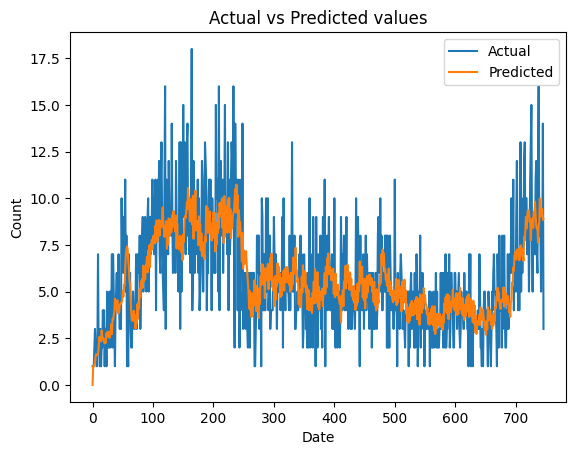

In [44]:
# Get predicted values
pred = model_fit.predict(dynamic=False)

# Plot the actual and predicted values
plt.plot(ds.index, ds['count'], label='Actual')
plt.plot(ds.index, pred, label='Predicted')
plt.title('Actual vs Predicted values')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

In [45]:
preds = model_fit.forecast(16)
preds = preds.tolist()
preds = [int(item) for item in preds]
months = [
    '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', 
    '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', 
    '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', 
    '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'
]

new_df = pd.DataFrame()
new_df['month_year'] = months
new_df['count'] = preds
data = pd.concat([ds, new_df])

fig = px.line(
    data, 
    x="month_year", 
    y="count", 
    title='Launches per month prediction'
)

fig.show()

<a id="7"></a>
<h2 style='background:black; border:0; color:white'><center>7. Where does India stand<center><h2>

In [46]:
compare = df[(df['country'] == 'India') | (df['country'] == 'USA')]
india = compare[compare['country']=='India']
years = india['year'].unique()
years.sort()
years

array([1979, 1980, 1981, 1983, 1987, 1988, 1989, 1993, 1994, 1996, 1997,
       1999, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

In [47]:
compare = compare[compare['year']>=1979]
ds = compare['country'].value_counts().reset_index()
ds.columns = ['country', 'count']
colors = ['#1f77b4', '#ff7f0e']
title_font = dict(size=20, color='#444444', family='Arial')

fig = px.pie(ds, 
             names='country', 
             values='count', 
             title='Number of Launches by Country',
             hole=0.5, # Change hole size
             color_discrete_sequence=colors, # Assign custom colors
             labels={'count': 'Number of Launches'}, # Rename labels
             width=700, 
             height=500)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_font=title_font)
fig.show()

In [48]:
ds = compare.groupby(['year', 'country'])['Status Mission'].count().reset_index()
ds.columns = ['year', 'country', 'Launches']
total = ds
colors = ['rgb(255, 128, 0)', 'rgb(53, 83, 255)']
fig = px.line(
    ds, 
    x="year", 
    y="Launches", 
    color='country', 
    title='USA vs India: Launches Year by Year',
    color_discrete_sequence=colors, # Set custom color palette
    labels={'year': 'Year', 'Launches': 'Number of Launches', 'country': 'Country'}, # Rename labels
    height=500, 
    width=800
)
fig.update_xaxes(tickfont=dict(size=10))
fig.update_layout(
    legend=dict(
        title=None,
        orientation='h',
        yanchor='top',
        y=1.1,
        xanchor='left',
        x=0.75,
        font=dict(size=12)
    )
)
fig.show()

In [49]:
ds_total = compare.groupby(['year', 'country'])['Status Mission'].count().reset_index()
ds_total.columns = ['year', 'country', 'Total']
ds_success = compare[compare['Status Mission'] == 'Success'].groupby(['year', 'country'])['Status Mission'].count().reset_index()
ds_success.columns = ['year', 'country', 'Success']
ds_f = pd.merge(ds_total, ds_success, on=['year', 'country'], how='outer').fillna(0)
ds_f['Success_pct'] = ds_f['Success'] / ds_f['Total'] * 100
ds_mean = ds_f.groupby('country')['Success_pct'].mean().reset_index()

In [50]:
fig = px.pie(ds_mean, 
             values='Success_pct', 
             names='country',
             title='Mean Success Percentage for USA vs India',
             color_discrete_sequence=['#1f77b4', '#ff7f0e'], 
             hole=0.5,
             labels={'country': 'Country', 'Success_pct': 'Mean Success Percentage'},
             width=700, 
             height=500)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_font=title_font)
fig.show()

In [51]:
# Create a Plotly bar plot
fig = px.bar(ds_f, x='year', y='Success_pct', color='country',
             title='Success Percentage of USA vs India',
             height=500, width=800,
             color_discrete_sequence=['#1f77b4', '#ff7f0e'])
fig.update_layout(xaxis_title='Year', yaxis_title='Success Percentage')
fig.show()

In [52]:
trace1 = go.Scatter(
    x=ds_f[ds_f['country'] == 'USA']['year'],
    y=ds_f[ds_f['country'] == 'USA']['Success_pct'],
    name='USA',
    line=dict(color='#1f77b4', width=2)
)
trace2 = go.Scatter(
    x=ds_f[ds_f['country'] == 'India']['year'],
    y=ds_f[ds_f['country'] == 'India']['Success_pct'],
    name='India',
    line=dict(color='#ff7f0e', width=2)
)
data = [trace1, trace2]
layout = go.Layout(
    title='Success Percentage by Year and Country',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Success Percentage')
)
fig = go.Figure(data=data, layout=layout)
fig.show()